In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff10 as ds
from copy import copy as dup
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2

### The cell below specifies parameters for the 0-d and 1-d runs

<IPython.core.display.Javascript object>


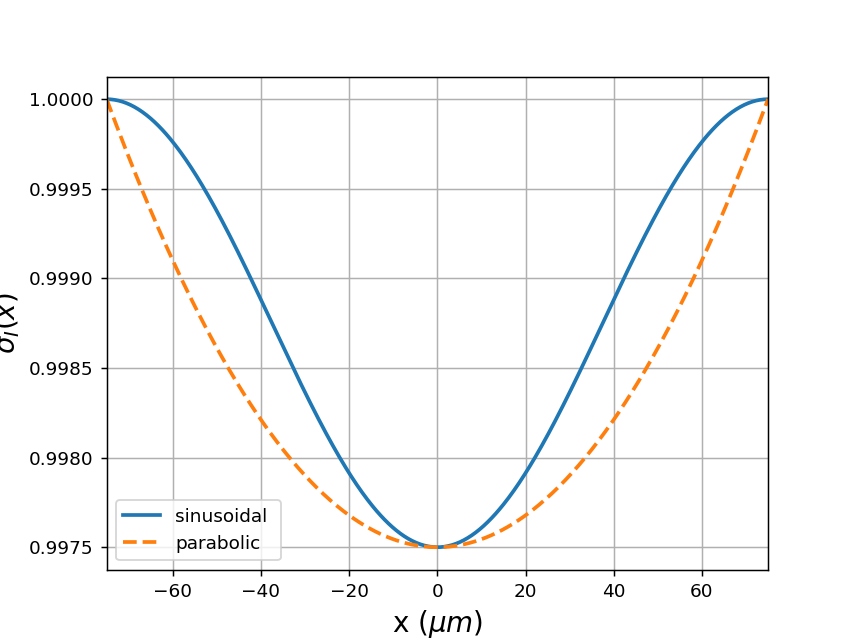

D = 0.00016 um^2/us 0.16 x 10^-9 m^2/sec
deltat_max (Diffusion time) = 562.4999999999999
deltat = 11.249999999999998
nu_kin_mlyperus = 0.8333333333333334 monolayers/us
nmid = 250
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.3
sigma_0 = 0.19
sigmaIcorner = 0.22
center reduction = 0.25 %
c_r = 0.0025 dimensionless
max growth rate = 55.00000000000001 um/sec
min growth rate = 7.5 um/sec
nu_kin = 250 um/sec
dx = 0.3
L = 75.0 micrometers


In [3]:
#Setting up the system
nx = 501 # Number of points in simulation box
xmax = 150
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
nmid = int(nx/2)
xmid = max(x)/2
xmax = x[nx-1]
L = xmax/2

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
# D = 2e-4 # micrometers^2/microsecond
D = 1.6e-4 # micrometers^2/microsecond
# D = 5e-5 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 50
dtmax = deltax**2/D
t_init = 0.0
deltat = dtmax/dtmaxtimefactor
tinterval = [t_init, t_init+deltat]

# Deposition rate
nu_kin = 34 # microns/second - about right for 240 K
nu_kin = 49 # microns/second - between 240 and 260 K
nu_kin = 250 # microns/second - about right for 260 K
nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
sigma0 = 0.19
sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
sigmaIcorner = 0.22 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time step and space step
Doverdeltax2 = D/deltax**2

# Overlying supersaturation
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
# sigmaIstyle = 'sinusoid'
sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')
plt.figure()
plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
         x-xmid, sigmaI_parabolic/sigmaIcorner, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

# 0D run parameters
uselayers = True
if uselayers:
    layermax_0D = 100
else:
    countermax_0D = 100

# 1D run parameters
if uselayers:
    layermax_1D = 100
else:
    countermax_1D = 15000

# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time) =', dtmax)
print('deltat =', deltat)
print('nu_kin_mlyperus =', nu_kin_mlyperus, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', nu_kin_mlyperus*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', nu_kin_mlyperus*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')

### This is the 0-d run

In [17]:
# Bundle parameters for ODE solver
# params = np.array([Nbar, Nstar, sigmaIcorner, sigma0, nu_kin_mlyperus])
params = [Nbar, Nstar, sigmaIcorner, sigma0, nu_kin_mlyperus]
print(params)

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_0D = 1
NQLL_init_0D = ds.getNQLL(Ntot_init_0D,Nstar,Nbar)

# Initialize the keeper arrays
tkeep_0D = []
ykeep_0D = []
tlast = t_init

# Call the ODE solver
ylast = [NQLL_init_0D,Ntot_init_0D]
counter = 0
ttot = 0.0
while True:
    
    # Integrate up to next time step
#     y = odeint(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    y = solve_ivp(ds.f0d, ylast, tinterval, args=(params,),rtol=1e-12)
    ylast = list(y[1,:])
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Update counters and see whether to break
    NQLLlast, Ntotlast = ylast
    counter += 1
    if uselayers:
        if Ntotlast > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break

[1.0, 0.1432394487827058, 0.22, 0.19, 0.8333333333333334]


TypeError: cannot unpack non-iterable float object

In [13]:
# Convert results to a numpy array
ykeep_0D = np.array(ykeep_0D, np.float64)
NQLLkeep_0D = ykeep_0D[:,0]
Ntotkeep_0D = ykeep_0D[:,1]
tkeep_0Darr = np.array(tkeep_0D, np.float64)

0-D Modeled growth rate, um/s 17.88994987310851
0-D Modeled growth rate, ml/us 0.05963316624369503
0-D Modeled alpha 0.3252718158747002


<IPython.core.display.Javascript object>


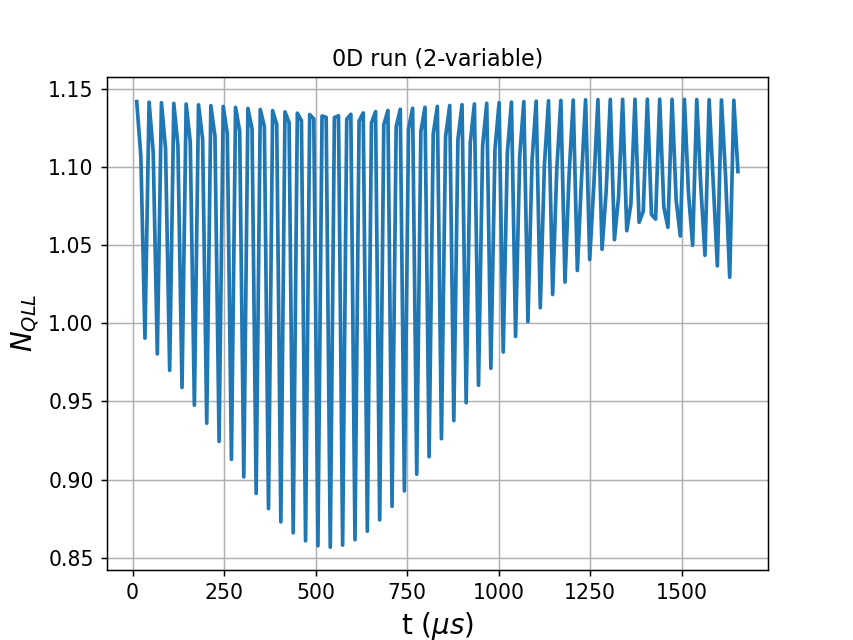

Text(0.5, 1.0, '0D run (2-variable)')

In [14]:
# Growth statistics
delta_Ntot_0D = Ntotkeep_0D[-1]-Ntot_init_0D
growthrate_0D_mlyperus = delta_Ntot_0D/tlast # monolayer/us
growthrate_0D = growthrate_0D_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0D)
print( "0-D Modeled growth rate, ml/us", growthrate_0D_mlyperus)
alpha_0D = growthrate_0D/nu_kin/sigmaIcorner
print( "0-D Modeled alpha", alpha_0D)
title = '0D run (2-variable)'

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0D[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.title(title)

### This is the 1-d run

In [8]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaI, sigma0, nu_kin_mlyperus, Doverdeltax2, nx] 

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)
NQLL_init_1D = ds.getNQLL(Ntot_init_1D,Nstar,Nbar)

# Initialize the keeper arrays
tkeep_1D = []
ykeep_1D = []
tlast = t_init

# Call the ODE solver
ylast = [NQLL_init_1D,Ntot_init_1D]
counter = 0
layer = 0
ttot = 0.0
while True:
    # Integrate up to next time step
    y = odeint(ds.f1d, np.reshape(ylast,2*nx), tinterval, args=(params,),rtol=1e-12)
    ylast = np.reshape(y[1],(2,nx))
    tlast += deltat
        
    # Stuff into keeper arrays
    ykeep_1D.append(ylast)
    tkeep_1D.append(tlast)

    # Make some local copies
    ttot += deltat

    # Update counters and see whether to break
    NQLLlast, Ntotlast = ylast
    minpoint = min(Ntotlast)
    maxpoint = max(Ntotlast)
    print(counter-1, int(Ntotlast[0]), maxpoint-minpoint)
    counter += 1
    if uselayers:
        if Ntotlast[0] > layermax_1D-1:
            break
    else:
        if counter > countermax_1D-1:
            break

-1 1 0.002492031510391568
0 2 0.00826304585929094
1 3 0.03331809156334842
2 3 0.010235959559901087
3 4 0.02324027113675875
4 5 0.06440655863613642
5 5 0.017896261712442296
6 6 0.0389986532304869
7 7 0.09360048713798186
8 7 0.025482611293692337
9 8 0.05571352441377719
10 9 0.12124108660125188
11 9 0.0330159568983337
12 10 0.07360852900676207
13 11 0.14762464701654388
14 11 0.04051723096039517
15 12 0.09294544737714361
16 13 0.17297818198112402
17 13 0.04800499864654739
18 14 0.11403240202585074
19 15 0.19748009738285432
20 15 0.05549879240729361
21 16 0.13723539253236794
22 17 0.22127145400698467
23 17 0.06301898239266635
24 18 0.16297827193416126
25 19 0.24445723044440726
26 19 0.07058577416785283
27 20 0.19173078709582114
28 21 0.26710775548672316
29 21 0.07822013120408755
30 22 0.22397744078033455
31 23 0.28926996258587323
32 23 0.08594480737895793
33 24 0.2601365131807043
34 25 0.310975299720738
35 25 0.09378469818878798
36 26 0.30040873381675226
37 27 0.33223799448587954
38 27 0.10

313 211 1.2931172315225297
314 211 1.3334685657091256
315 212 1.7875112111581473
316 213 1.2885735954851043
317 213 1.3593117200797167
318 214 1.7905120231613694
319 214 1.2844109702221544
320 215 1.3879401786604149
321 216 1.792986233500244
322 216 1.280638319781474
323 217 1.4192464345769054
324 218 1.79496057954168
325 218 1.27726418421841
326 219 1.452842208579625
327 220 1.7964556362690018
328 220 1.2742971612721021
329 221 1.488013166137307
330 222 1.7974863344941525
331 222 1.2717462878236176
332 223 1.5237657257510193
333 224 1.7980623024812417
334 224 1.269621357524727
335 225 1.5589845203720074
336 226 1.7981881877423405
337 226 1.2679333494895673
338 227 1.592647695386603
339 228 1.7978640049041417
340 228 1.2666949743567102
341 229 1.6239993747254857
342 230 1.7970853752843823
343 230 1.2659212529386537
344 231 1.6526133877848679
345 232 1.7958436146007841
346 232 1.2656300621025025
347 233 1.678356517147023
348 234 1.7941256589902252
349 234 1.2658426376436864
350 235 1.70

621 415 1.767258777034158
622 416 1.305035397171821
623 416 1.256540075959606
624 417 1.7633853716236558
625 418 1.283486574695587
626 418 1.2593327097927158
627 419 1.758832176179851
628 419 1.2642967878891227
629 420 1.2623646316435497
630 421 1.753539054078317
631 421 1.2471937261230437
632 422 1.2656227132646336
633 423 1.7474329537022868
634 423 1.2319151267212192
635 424 1.269092762909338
636 425 1.7404254274637196
637 425 1.218221292291446
638 426 1.2727592159854453
639 427 1.7324096451582136
640 427 1.205899599936231
641 428 1.2766048635764946
642 429 1.723256848879771
643 429 1.1947646820115096
644 430 1.2806105981808855
645 431 1.712812245180885
646 431 1.1846564986196313
647 432 1.2847551763123874
648 433 1.700890454591672
649 433 1.1754375609463068
650 434 1.2890150252086414
651 435 1.6872708987002625
652 435 1.166989967878635
653 436 1.2933640350548217
654 437 1.6716940182405438
655 437 1.1592125791536319
656 438 1.2977733961085391
657 439 1.6538602010612635
658 439 1.1520

931 620 0.009815466281793306
932 621 0.04395514846237347
933 621 0.03233349804202135
934 622 0.017242666767401715
935 623 0.07443031415152745
936 623 0.04724461925616197
937 624 0.0248457831766018
938 625 0.10801852595602668
939 625 0.0616454633614012
940 626 0.03254542211675471
941 627 0.14512949509799
942 627 0.07562160596319245
943 628 0.04035910561174205
944 629 0.18612258859013764
945 629 0.08924072796651217
946 630 0.04830776349149346
947 631 0.23107079220835658
948 631 0.10256135877580164
949 632 0.05641614792273231
950 633 0.27952308040050866
951 633 0.11562998504234656
952 634 0.06471211580856107
953 635 0.33029448867137035
954 635 0.128487200700647
955 636 0.0732278468565255
956 637 0.3815504952236779
957 637 0.14116252408393848
958 638 0.08200039412918159
959 639 0.43125323048911923
960 639 0.153684270472354
961 640 0.09107227757272085
962 641 0.4777124174030405
963 641 0.16607483277118718
964 642 0.10049390073606901
965 643 0.5199605796869946
966 643 0.17835654777547916
967

1229 817 1.7518308975656964
1230 818 1.2186271019849073
1231 819 1.4320786984769711
1232 819 1.752574828877755
1233 820 1.2189711197094084
1234 821 1.4685223154335745
1235 821 1.752758365015893
1236 822 1.2195626675901394
1237 823 1.5056481695643242
1238 823 1.7523865896050665
1239 824 1.2204210657810108
1240 825 1.5422408925285254
1241 825 1.7514585926816153
1242 826 1.2215671465393143
1243 827 1.577181803436929
1244 827 1.7499678528828326
1245 828 1.2230237522418292
1246 829 1.6096497171564579
1247 829 1.7479025261228571
1248 830 1.2248163034230402
1249 831 1.6391932747378632
1250 831 1.7452455659681618
1251 832 1.2269733648477086
1252 833 1.6656856998125704
1253 833 1.741974715003721
1254 834 1.2295272060326852
1255 835 1.6892251642807423
1256 835 1.738062414841579
1257 836 1.2325143586840568
1258 837 1.710035892715723
1259 837 1.7334757198429998
1260 838 1.2359762723225458
1261 838 1.7283951340690464
1262 839 1.728176322326476
1263 840 1.2399601586427025
1264 840 1.744588025677217


In [9]:
# Convert results to a numpy array
ykeep_1D = np.array(ykeep_1D, np.float64)
NQLLkeep_1D = ykeep_1D[:,0]
Ntotkeep_1D = ykeep_1D[:,1]
tkeep_1Darr = np.array(tkeep_1D, np.float64)

1-D growth rate, ml/us 0.05894190369865718
1-D growth rate, um/s 17.682571109597152
1-D alpha 0.3215012929017664
slowdown -0.86 %
Libbrecht's predicted growth rate 10.705216497342732 um/s
Libbrecht's predicted alpha 0.19464029995168605


<IPython.core.display.Javascript object>


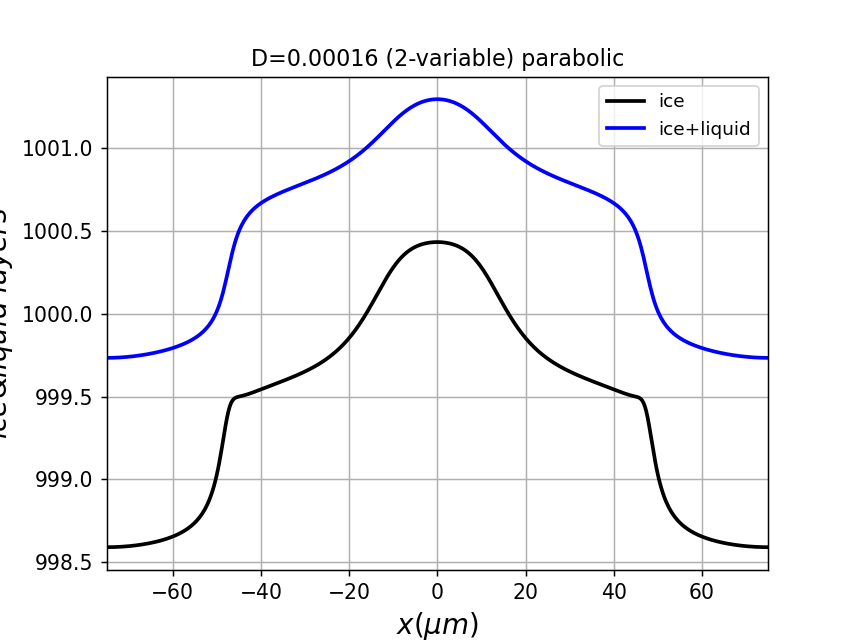

<IPython.core.display.Javascript object>


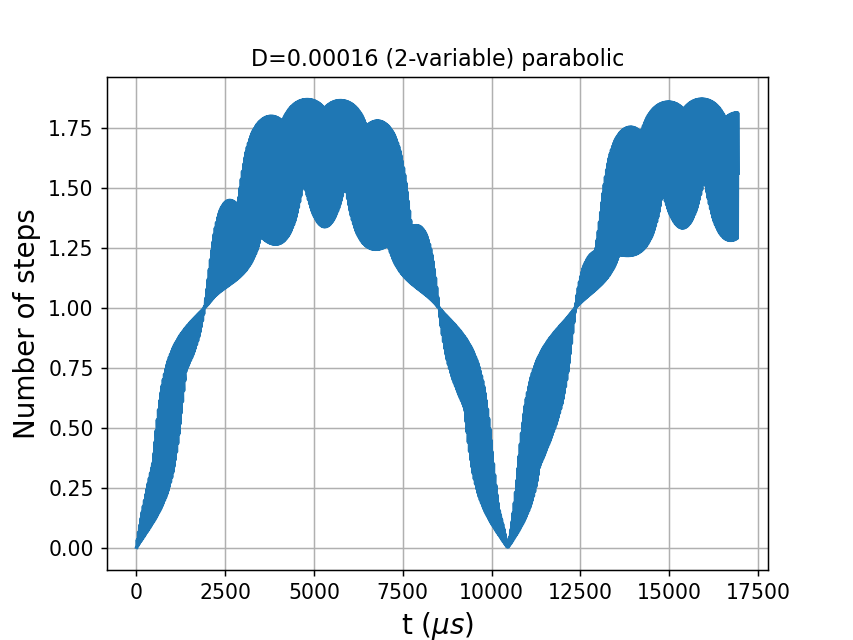

<IPython.core.display.Javascript object>


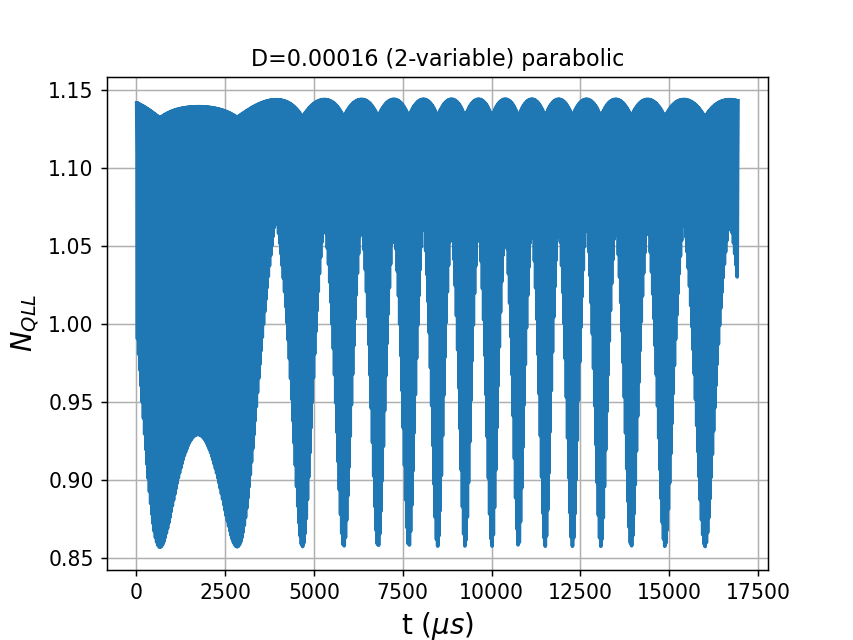

In [10]:
# Growth statistics
delta_Ntot_1D = Ntotkeep_1D[-1,0]-Ntotkeep_1D[0,0]
growthrate_1D_mlyperus = delta_Ntot_1D/tlast; print( "1-D growth rate, ml/us", growthrate_1D_mlyperus)
growthrate_1D = growthrate_1D_mlyperus*umpersec_over_mlyperus; print( "1-D growth rate, um/s", growthrate_1D)
alpha_1D = growthrate_1D/nu_kin/sigmaIcorner; print( "1-D alpha", alpha_1D)
slowdown = (alpha_1D-alpha_0D)/alpha_0D*100; print("slowdown", int(slowdown*100)/100,'%')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D
title = 'D='+str(D)+' (2-variable) '+sigmaIstyle

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate", nu_kin*alpha_L*sigmaIcorner, "um/s")
print("Libbrecht's predicted alpha", alpha_L)

# Plot ice and liquid
plt.figure()
plt.plot(x-xmid, Nicekeep_1D[-1,:], 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Ntotkeep_1D[-1,:], 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot number of steps over time
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
plt.plot(tkeep_1D,f,lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel('Number of steps',fontsize=fontsize)
plt.title(title)
plt.grid('on')

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_1D,NQLLkeep_1D[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.title(title)
plt.grid('on')

### The cell below is just backup for parameters, and allows some exploration (but not part of the simulation)

In [11]:
# The time required for an initial gaussian to diffuse
layer_growth_rate = growthrate_0D/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
t1 = 1/layer_growth_rate; print('Time_to_add_a_layer =', t1)
t2 = 2.5**2/D; print('Time to diffuse across a terrace =', t2)
t3 = 0.2**2/D; print('Time to diffuse into a step =', t3)
t4 = 0.001; print('Time for ice-QLL equilibration =', t4)

# How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
D_old = 2e-6
D_new = D_old/50**2*100**2; print(D_new)

# Computing the kinetic deposition velocity ... roughly, 260 
import numpy as np
M = 18 # g/mol
T = 260 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
M = 18 # g/mol
T = 240 # K
NA = 6.02e23
m = M/NA; print(m,'mass of a molecule of water, grams/mol')
m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
R = 8.314 # J/K-mol
k = R/NA; print(k,"Boltzmann's constant, J/K")

Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
V_gas = R*T/Pvap # Must be in m^3
V_gas *= (10/1)**3; print(V_gas, 'Liters') 
V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
c_sat = 1/V_gas # mol/cm^3
c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
V_solid = 1/c_solid # cm^3/g

V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# Gladich et al recommendation
D_Gladich = 0.16e-9 # m^2/s
D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)

Layer growth rate = 0.05945625791705377
Time_to_add_a_layer = 16.81908742718184
Time to diffuse across a terrace = 39062.5
Time to diffuse into a step = 250.00000000000003
Time for ice-QLL equilibration = 0.001
8e-06
2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
10808.199999999999 Liters
10808199.999999998 cm^3
1.6654021946300035e-06 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
9943543.999999998 ratio of volumes
1.810219776771743e-06 ratio of densities
0.0002502630900698087 kinetic velocity, m/s
250.26309006980867 kinetic velocity, um/s
2.990033222591362e-23 mass of a molecule of water, grams/mol
2.9900332225913625e-26 mass of a molecule of water, kg/mol
1.381063122923588e-23 Boltzmann's constant, J/K
76744.61538461539 Liters
76744615.38461539 cm^3
2.345441424103921e-07 density of vapor, g/cm^3
0.92 density of ice, g/cm^3
70605046.15384616 ratio of volumes
2

In [12]:
# # Plot liquid only
# plt.figure()
# plt.plot(x-xmid, NQLL, 'g', label='liquid', lw=linewidth)
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel(r'$liquid \ layers$',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.legend()
# plt.title(title)
# plt.grid('on')

# # Plot derivatives
# dydx = ds.f1d(ylast,0,params)
# dydx = np.reshape(dydx,(2,nx))
# plt.figure()
# plt.plot(x-xmid, dydx[0,:], 'g', label='liquid derivative', lw=linewidth)
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel('dNQLL/dt',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.legend()
# plt.title(title)
# plt.grid('on')

# # Plot sigma_m
# sigD = ds.f1d_sigma_m(ylast,0,params)
# plt.figure()
# plt.plot(x-xmid, sigD, 'g', label='sigD', lw=linewidth)
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel('sigma',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.legend()
# plt.title(title)
# plt.grid('on')

# # Plot sigma
# plt.figure()
# plt.plot(x-xmid, sigmaI, 'g', label='sigstep', lw=linewidth)
# plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
# plt.ylabel('sigma',fontsize=fontsize)
# plt.xlim([-xmid, xmid])
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.legend()
# plt.title(title)
# plt.grid('on')

# # The liquid over time
# ix = 0
# Ntotkeep_at_one_position = np.array(Ntotkeep)[:,ix]
# plt.figure()
# plt.plot(tkeep, Ntotkeep_at_one_position, 'b', label='total', lw=linewidth)
# plt.xlabel('time',fontsize=fontsize)
# plt.ylabel('layers',fontsize=fontsize)
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.grid('on')
# plt.title('Ntot '+title)

# # 
# ix = 0
# NQLLkeep_at_one_position = np.array(NQLLkeep)[:,ix]
# plt.figure()
# plt.plot(tkeep, NQLLkeep_at_one_position, 'b', label='liquid', lw=linewidth)
# plt.xlabel('time',fontsize=fontsize)
# plt.ylabel('layers',fontsize=fontsize)
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.grid('on')
# plt.title('NQLL '+title)


# Ntot_difference = np.array(Ntotkeep)[:,-1] - np.array(Ntotkeep)[:,nmid]
# plt.figure()
# plt.plot(tkeep, Ntot_difference, 'b', label='number of steps', lw=linewidth)
# plt.xlabel('time',fontsize=fontsize)
# plt.ylabel('layers',fontsize=fontsize)
# rcParams['xtick.labelsize'] = ticklabelsize 
# rcParams['ytick.labelsize'] = ticklabelsize
# plt.grid('on')
# plt.title('Layer difference (max-min) '+title)